In [1]:
import numpy as np
import pandas as pd
import os
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
# Load the main album and year data
albums_df = pd.read_csv('dataset/Album_Lists.csv')

# Directory containing the albums
album_dir = 'dataset'

# List to hold track data
track_data = []

# Expected columns in each album CSV
expected_columns = ['ID', 'Tracks']

# Iterate through each album file and load track data
for album in albums_df['Album']:
    album_file = os.path.join(album_dir, album, f'{album}.csv')
    if os.path.exists(album_file):
        album_tracks = pd.read_csv(album_file)
        if 'Unnamed: 0' in album_tracks.columns:
            album_tracks = album_tracks.drop(columns=['Unnamed: 0'])  # Drop the unnecessary column
        for col in expected_columns:
            if col not in album_tracks.columns:
                album_tracks[col] = None
        
        album_tracks = album_tracks[expected_columns]  # Keep only expected columns
        album_tracks['Album'] = album  # Add the album name to each track entry
        track_data.append(album_tracks)
    else:
        print(f"File not found: {album_file}")

# Combine all track data into a single DataFrame
tracks_df = pd.concat(track_data, ignore_index=True)

print(f"Combined DataFrame:\n{tracks_df.head(100)}")

Combined DataFrame:
          ID                                Tracks  \
0   10024009                             Fortnight   
1   10024578         The Tortured Poets Department   
2   10024528  My Boy Only Breaks His Favorite Toys   
3   10024535                              Down Bad   
4   10024536                       So Long, London   
..       ...                                   ...   
95   6688213                Mine (Taylors Version)   
96   6688225          Sparks Fly (Taylors Version)   
97   6688226    Back To December (Taylors Version)   
98   6688227           Speak Now (Taylors Version)   
99   6688228           Dear John (Taylors Version)   

                             Album  
0   The Tortured Poets Departement  
1   The Tortured Poets Departement  
2   The Tortured Poets Departement  
3   The Tortured Poets Departement  
4   The Tortured Poets Departement  
..                             ...  
95                       Speak Now  
96                       Speak Now 

In [3]:
def format_track_name(track_name):
    # Replace non-alphanumeric characters with underscores and remove spaces
    formatted_name = re.sub(r'[^A-Za-z0-9]+', '_', track_name.replace(' ', ''))
    return formatted_name

# Apply the function to create a new column for formatted track names
tracks_df['formatted_track_name'] = tracks_df['Tracks'].apply(format_track_name)

# Function to load lyrics from a text file based on the formatted track name
def load_lyrics(formatted_track_name):
    for album in albums_df['Album']:
        lyric_file = os.path.join(album_dir, album, f'{formatted_track_name}.txt')
        if os.path.exists(lyric_file):
            with open(lyric_file, 'r', encoding='utf-8') as file:
                return file.read()
    return None

# Apply the function to load lyrics for each track
tracks_df['lyrics'] = tracks_df['formatted_track_name'].apply(load_lyrics)

# Filter tracks with no lyrics
tracks_with_no_lyrics = tracks_df[tracks_df['lyrics'].isna()]

print(tracks_with_no_lyrics[['Tracks', 'Album']])
print(tracks_df.head(50))
print(tracks_df[['Album','Tracks']])

# Merge the album data with track data
merged_df = pd.merge(tracks_df, albums_df, on='Album')

Empty DataFrame
Columns: [Tracks, Album]
Index: []
          ID                                Tracks  \
0   10024009                             Fortnight   
1   10024578         The Tortured Poets Department   
2   10024528  My Boy Only Breaks His Favorite Toys   
3   10024535                              Down Bad   
4   10024536                       So Long, London   
5   10024520                  But Daddy I Love Him   
6   10024544                 Fresh Out The Slammer   
7   10291434                            Florida!!!   
8   10024517                        Guilty as Sin?   
9   10024563         Whos Afraid of Little Old Me?   
10  10024518       I Can Fix Him (No Really I Can)   
11  10024526                                  loml   
12  10024512       I Can Do It With A Broken Heart   
13  10024519       The Smallest Man Who Ever Lived   
14  10024521                           The Alchemy   
15  10024516                             Clara Bow   
16  10124160                   

In [4]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize necessary tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /home/ayusee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ayusee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ayusee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Define cleaning functions
def clean_lyrics(lyrics):
    if lyrics:
        lyrics = lyrics.lower()
        # Remove metadata or annotations within square brackets or parentheses
        lyrics = re.sub(r'\[.*?\]|\(.*?\)', '', lyrics)
        # Remove specific unwanted characters while keeping useful punctuation
        lyrics = re.sub(r'[!\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '', lyrics)
        # Remove digits if they are not part of the core lyrics
        lyrics = re.sub(r'\d+', '', lyrics)
        # Normalize whitespace
        lyrics = re.sub(r'\s+', ' ', lyrics).strip()
    return lyrics

def remove_stopwords(lyrics):
    if lyrics:
        words = lyrics.split()
        filtered_words = [word for word in words if word not in stop_words]
        return ' '.join(filtered_words)
    return lyrics

def tokenize_and_lemmatize(lyrics):
    if lyrics:
        tokens = word_tokenize(lyrics)
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return ' '.join(lemmatized_tokens)
    return lyrics

# Apply cleaning functions to the lyrics column
merged_df['cleaned_lyrics'] = merged_df['lyrics'].apply(clean_lyrics)
merged_df['cleaned_lyrics'] = merged_df['cleaned_lyrics'].apply(remove_stopwords)
merged_df['processed_lyrics'] = merged_df['cleaned_lyrics'].apply(tokenize_and_lemmatize)

print(merged_df[['Album', 'Tracks', 'processed_lyrics']].head())

                            Album                                Tracks  \
0  The Tortured Poets Departement                             Fortnight   
1  The Tortured Poets Departement         The Tortured Poets Department   
2  The Tortured Poets Departement  My Boy Only Breaks His Favorite Toys   
3  The Tortured Poets Departement                              Down Bad   
4  The Tortured Poets Departement                       So Long, London   

                                    processed_lyrics  
0  contributorstranslationsfrançaisitalianotürkçe...  
1  contributorstranslationstürkçeportuguêsespañol...  
2  contributorstranslationsespañolالعربيةفارسیсрп...  
3  contributorstranslationstürkçeportuguêsespañol...  
4  contributorstranslationstürkçeportuguêsespañol...  


In [6]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, token_pattern=r'[a-zA-Z]+', max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the processed lyrics
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_df['processed_lyrics'].dropna())

# Convert the TF-IDF matrix to a DataFrame for easier inspection
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print(tfidf_df.head(10))

   accident  account  ace  achilles  acid  act  actress  actually  add  \
0       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
1       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
2       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
3       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
4       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
5       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
6       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
7       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
8       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.068441  0.0   
9       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   

   addicted  ...  yeah  yeahembed      year     yes  yesterday  york  \
0       0.0  ...   0.0        0.0  0.000000  0.0000        0.0   0.0   
1       0.0  ...   0.0        0.0  0.0000

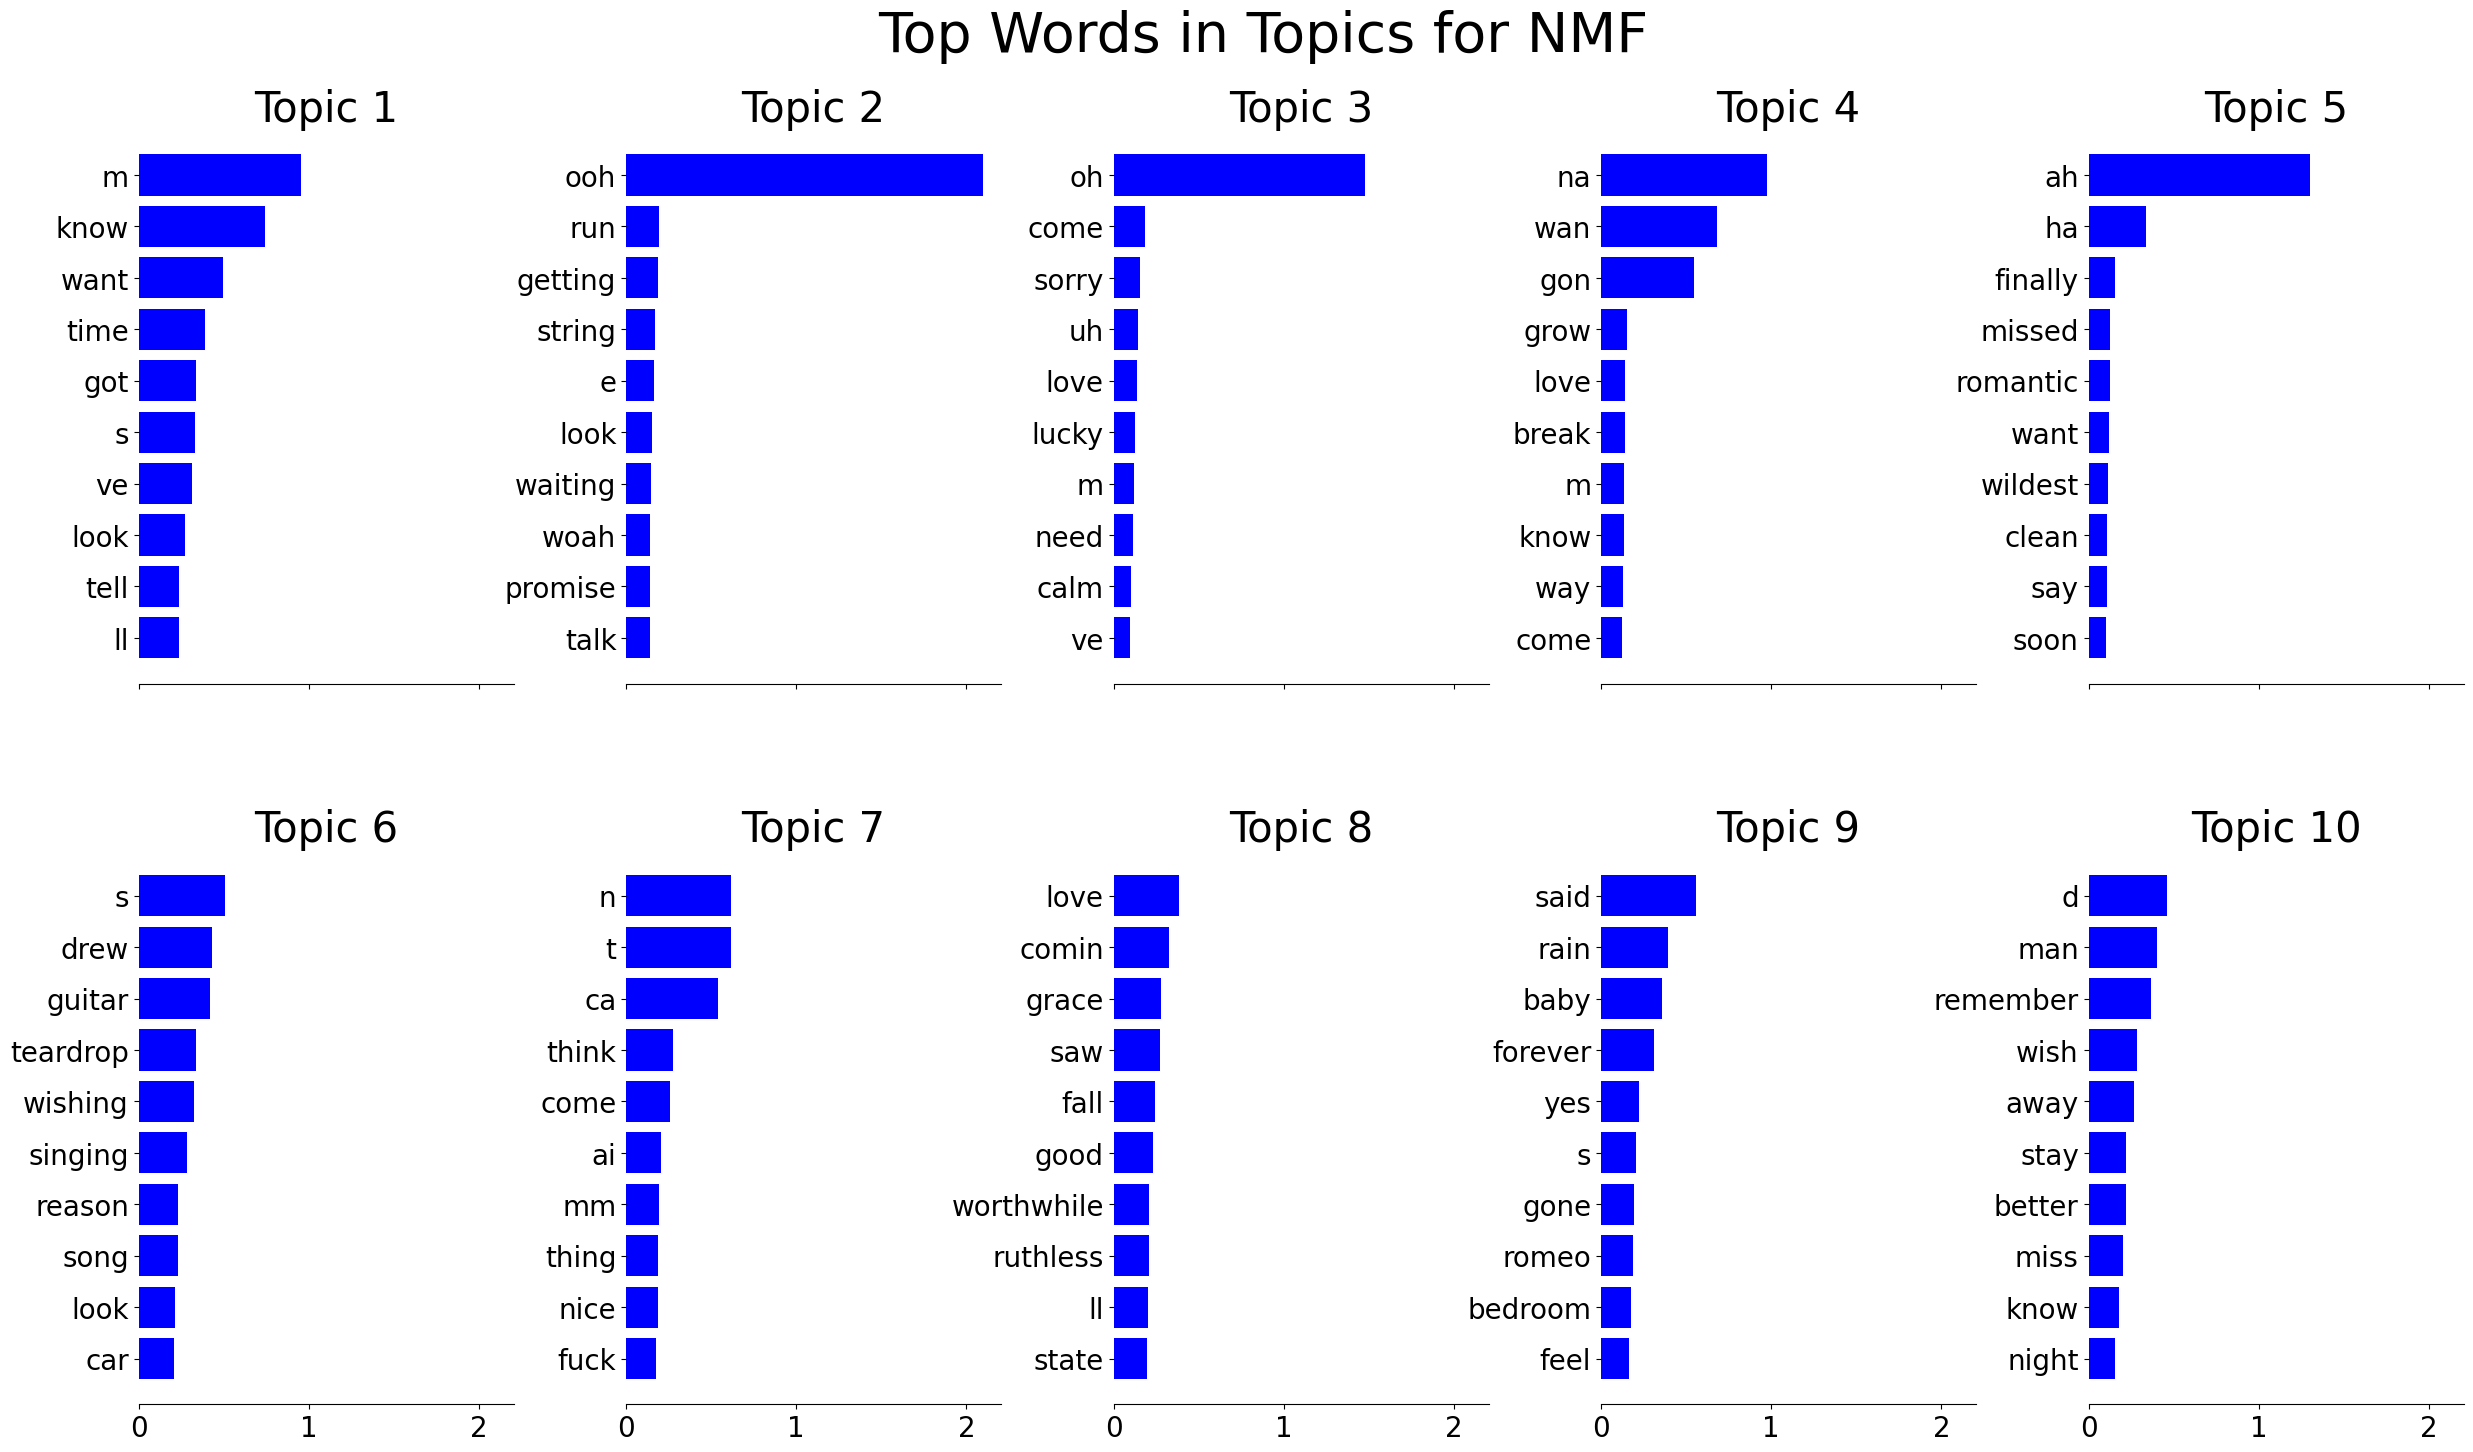

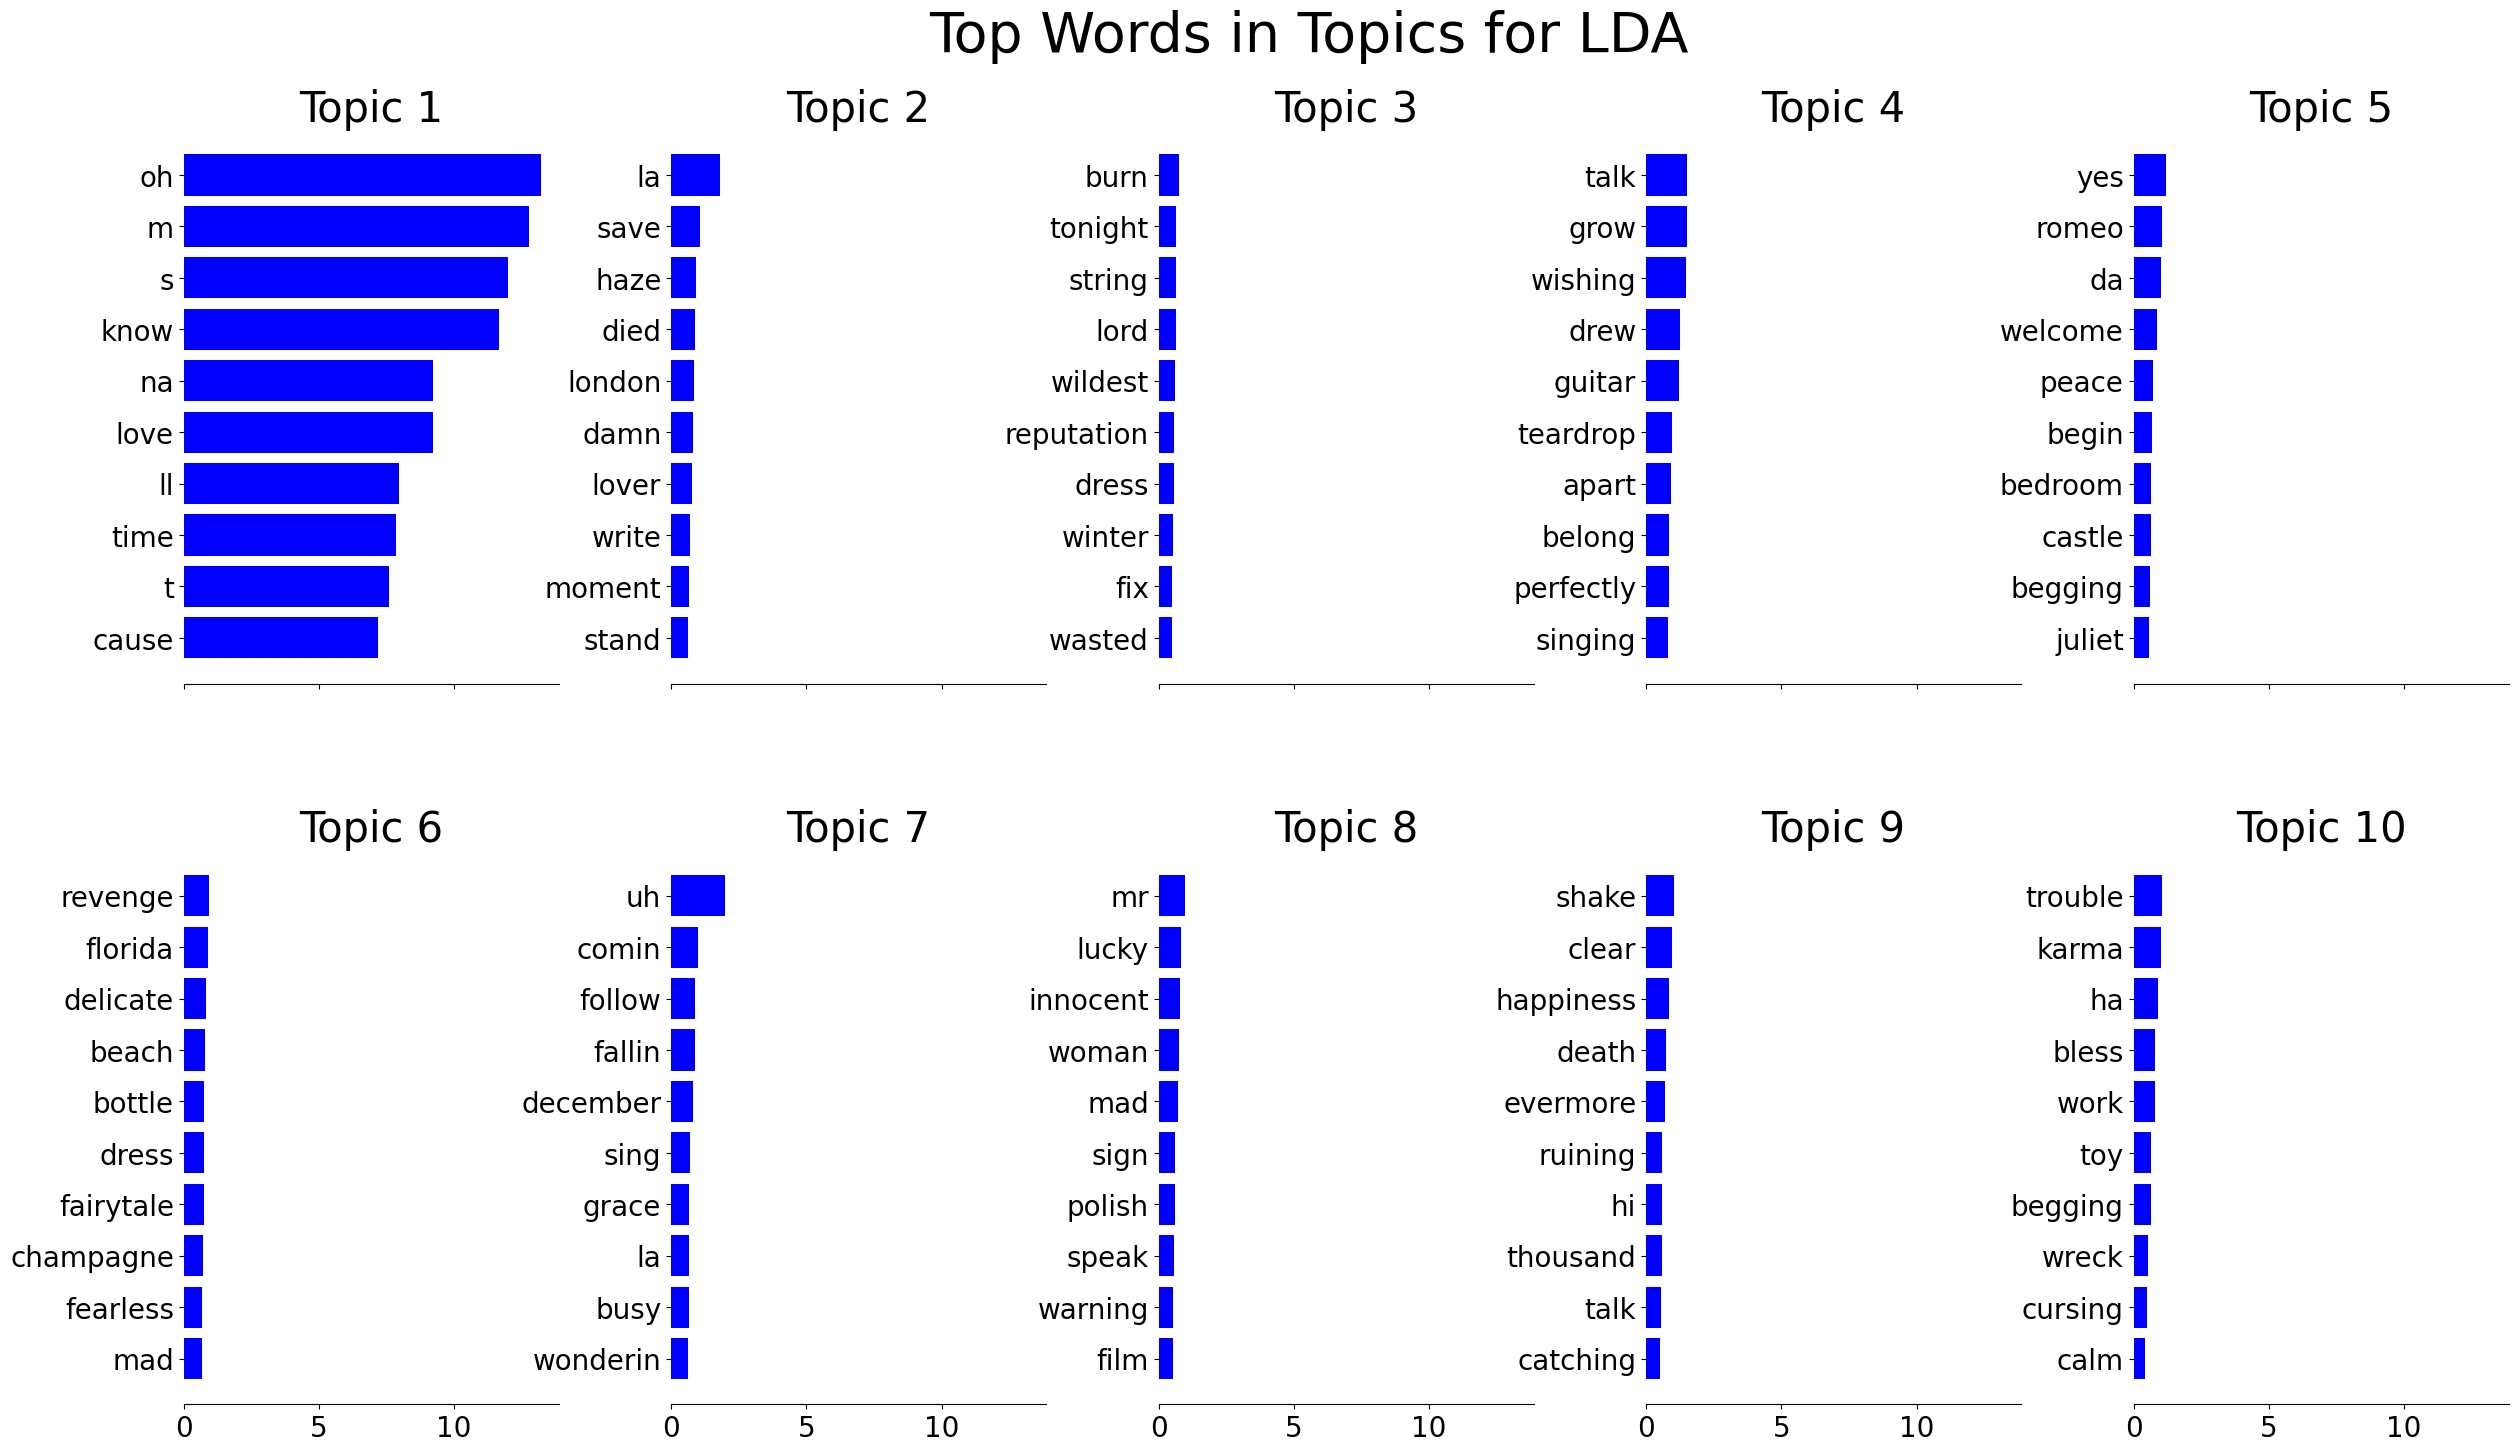

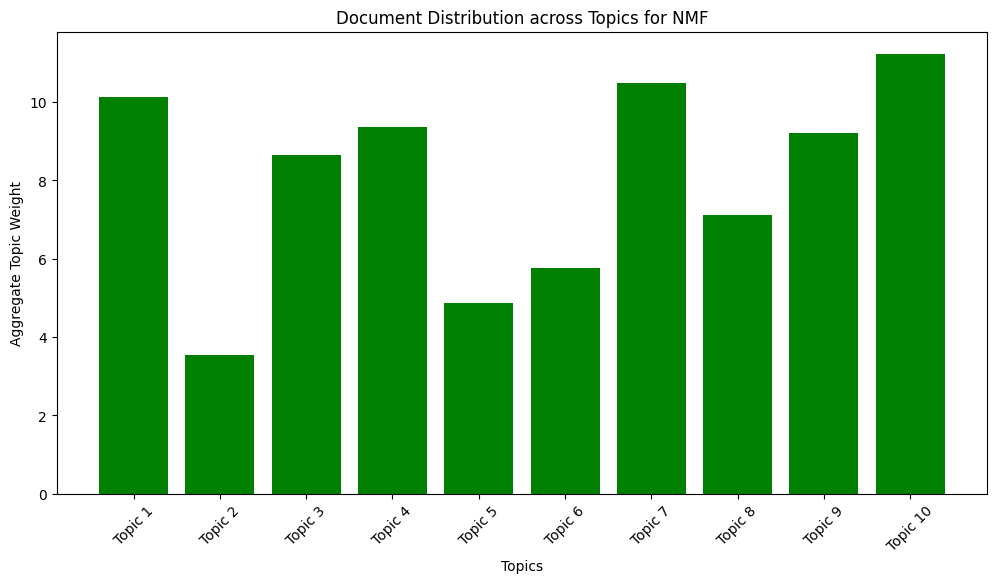

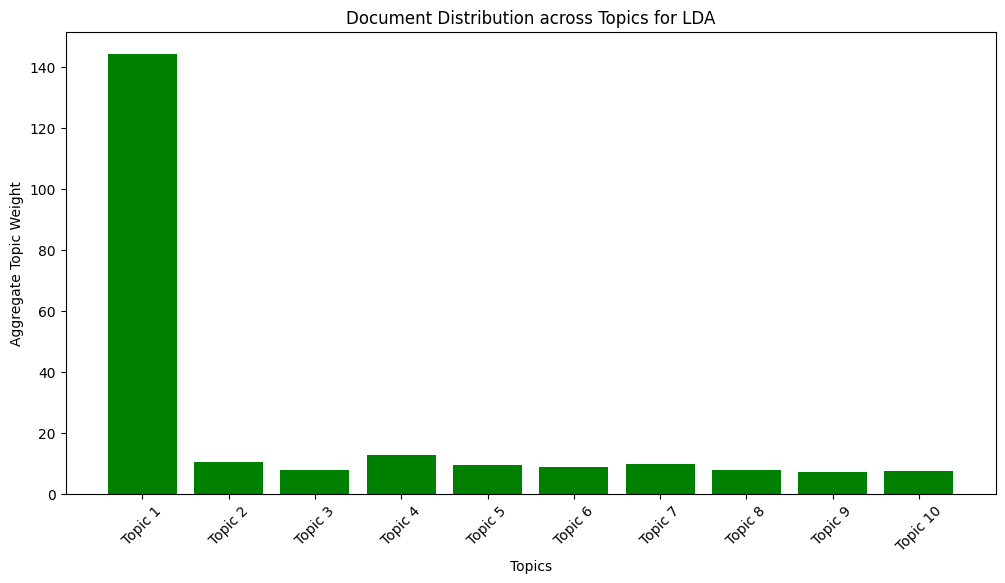

In [7]:
# Topic Modeling - NMF
nmf_model = NMF(n_components=10)
nmf_topics = nmf_model.fit_transform(tfidf_matrix)

# Topic Modeling - LDA
lda_model = LatentDirichletAllocation(n_components=10)
lda_topics = lda_model.fit_transform(tfidf_matrix)

# Visualizing the Top Words for Each Topic
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(int(n_top_words/5), 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, color='blue')
        ax.set_title(f'Topic {topic_idx+1}', fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, hspace=0.3, wspace=0.3)
    plt.show()

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(nmf_model, tfidf_feature_names, 10, 'Top Words in Topics for NMF')
plot_top_words(lda_model, tfidf_feature_names, 10, 'Top Words in Topics for LDA')

# Visualizing Document Distribution Over Topics
def plot_document_topics(model_output, title):
    # Aggregate the topic distribution for visualization
    topic_distribution = np.sum(model_output, axis=0)
    topic_indices = [f"Topic {i+1}" for i in range(len(topic_distribution))]
    
    plt.figure(figsize=(12, 6))
    plt.bar(topic_indices, topic_distribution, color='green')
    plt.xlabel('Topics')
    plt.ylabel('Aggregate Topic Weight')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_document_topics(nmf_topics, 'Document Distribution across Topics for NMF')
plot_document_topics(lda_topics, 'Document Distribution across Topics for LDA')

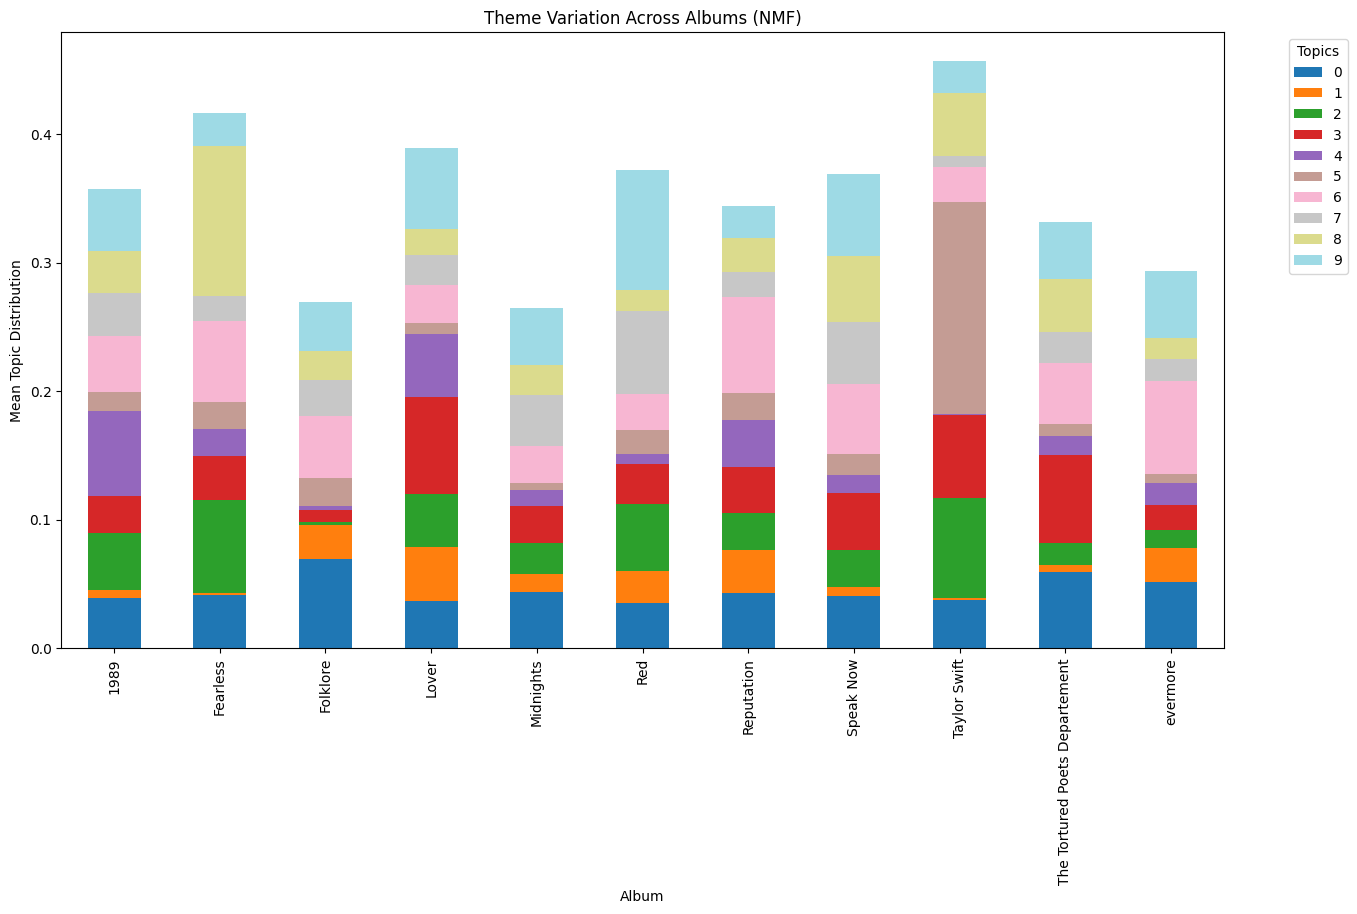

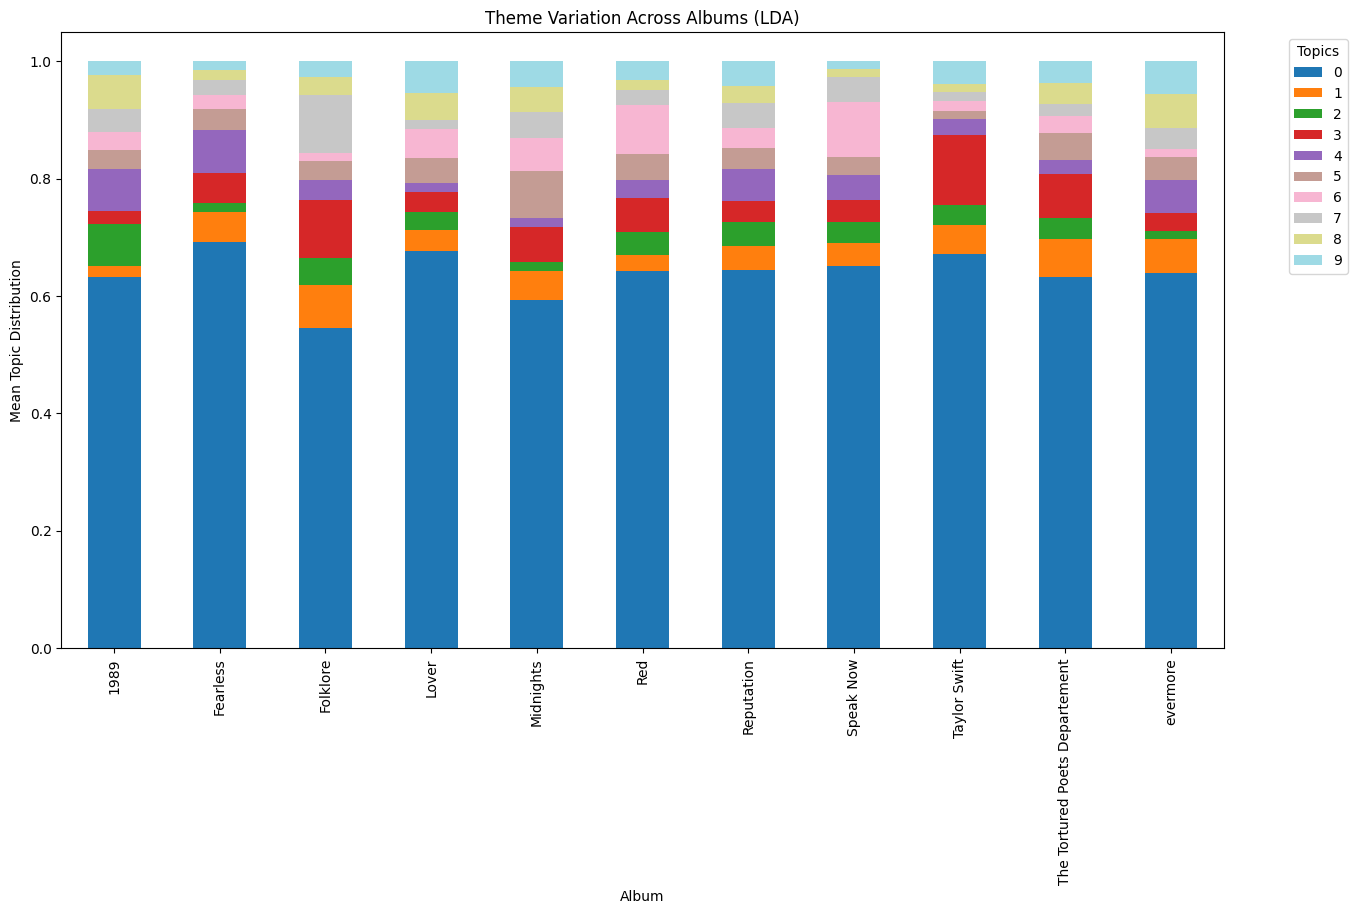

In [8]:
# Analyze theme variation across different albums
merged_df_nmf = pd.concat([merged_df.reset_index(drop=True), pd.DataFrame(nmf_topics)], axis=1)
merged_df_lda = pd.concat([merged_df.reset_index(drop=True), pd.DataFrame(lda_topics)], axis=1)

# Ensure only numeric columns are considered
numeric_columns_nmf = merged_df_nmf.select_dtypes(include=[np.number]).columns
numeric_columns_lda = merged_df_lda.select_dtypes(include=[np.number]).columns

# Group by album and calculate mean topic distribution
album_nmf_distribution = merged_df_nmf.groupby('Album')[numeric_columns_nmf].mean().iloc[:, -10:]
album_lda_distribution = merged_df_lda.groupby('Album')[numeric_columns_lda].mean().iloc[:, -10:]

# Plotting theme variation across albums
def plot_theme_variation(album_distribution, model_name):
    album_distribution.plot(kind='bar', stacked=True, figsize=(15, 8), colormap='tab20')
    plt.title(f'Theme Variation Across Albums ({model_name})')
    plt.xlabel('Album')
    plt.ylabel('Mean Topic Distribution')
    plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

plot_theme_variation(album_nmf_distribution, 'NMF')
plot_theme_variation(album_lda_distribution, 'LDA')

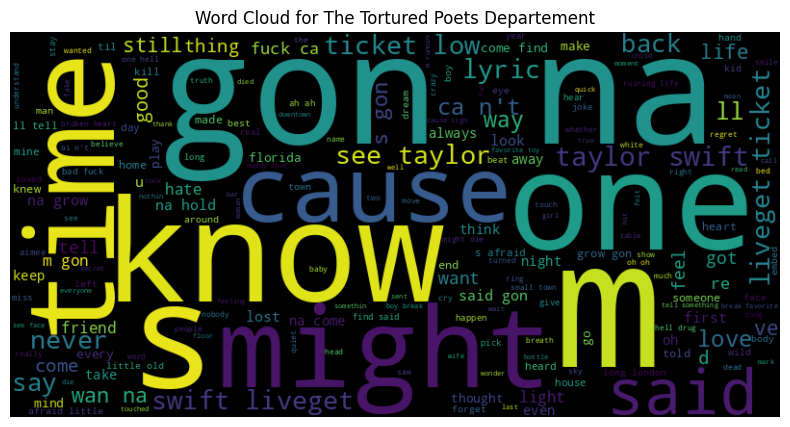

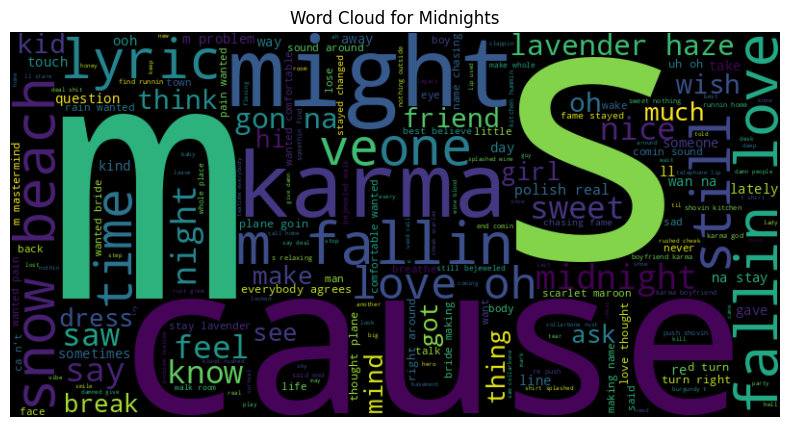

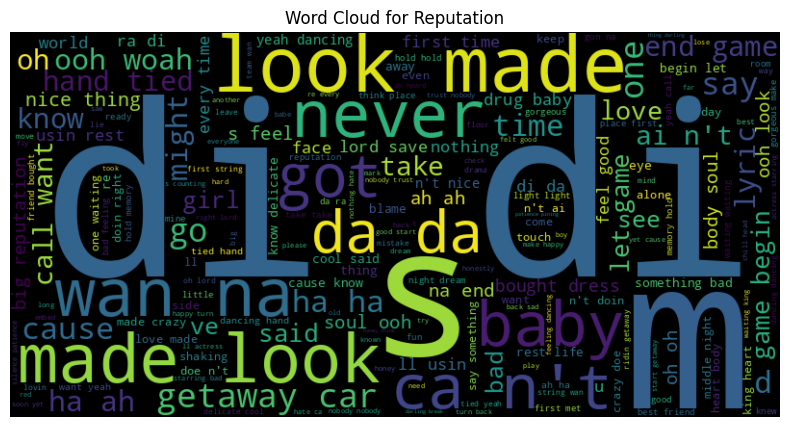

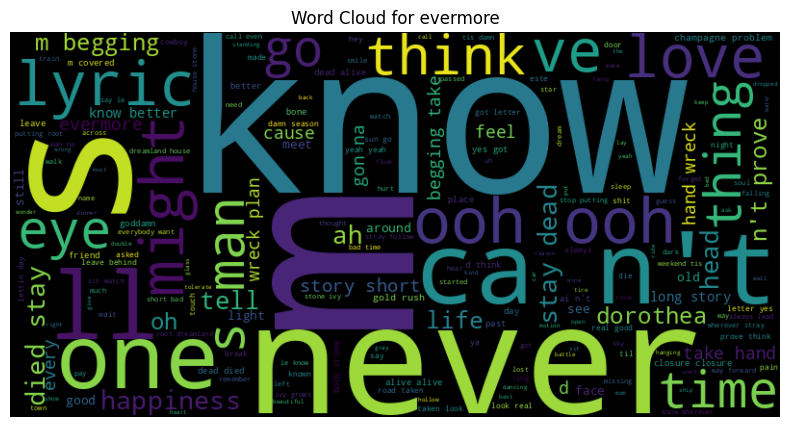

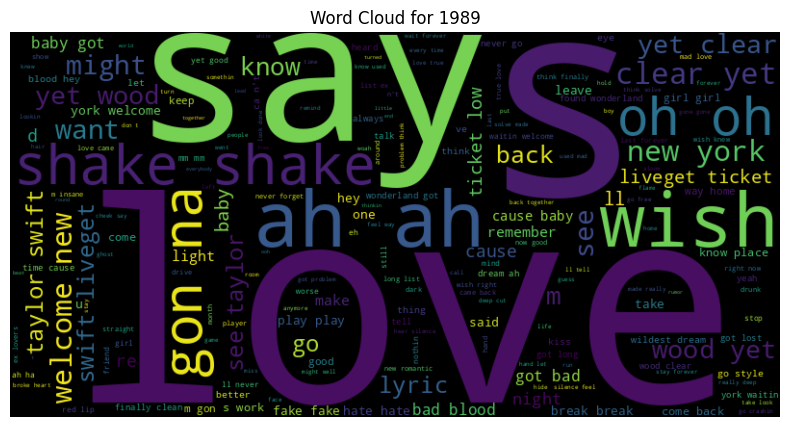

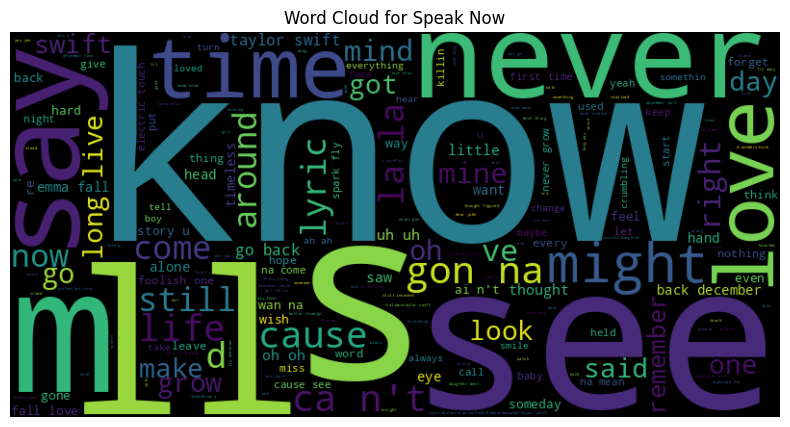

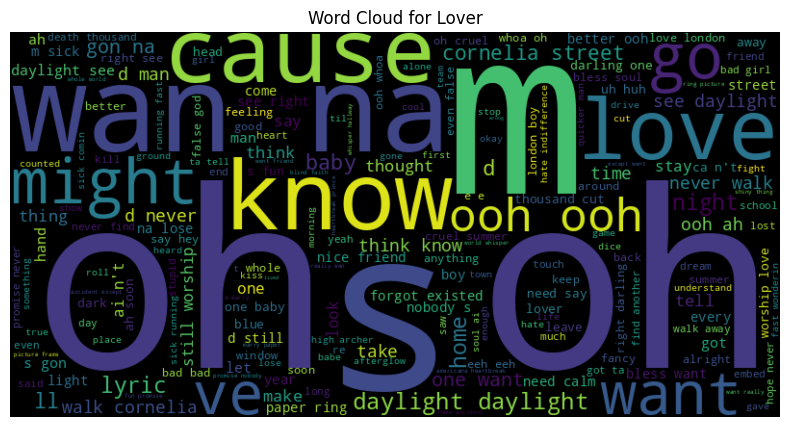

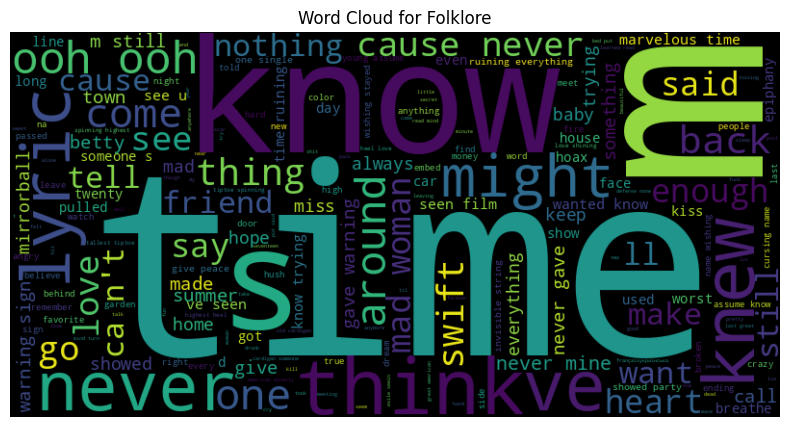

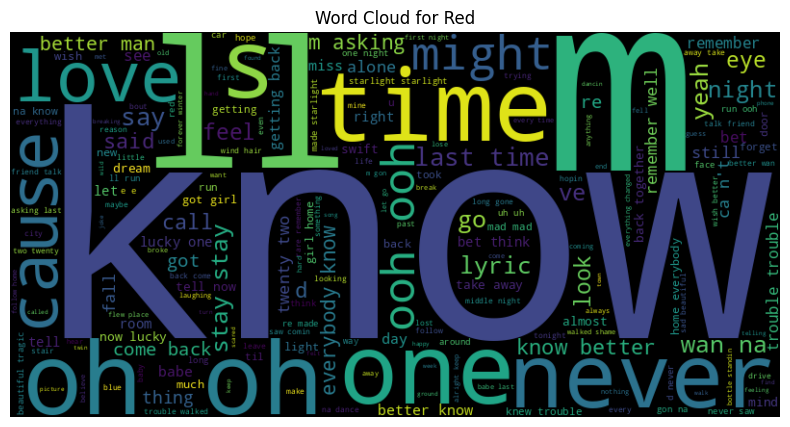

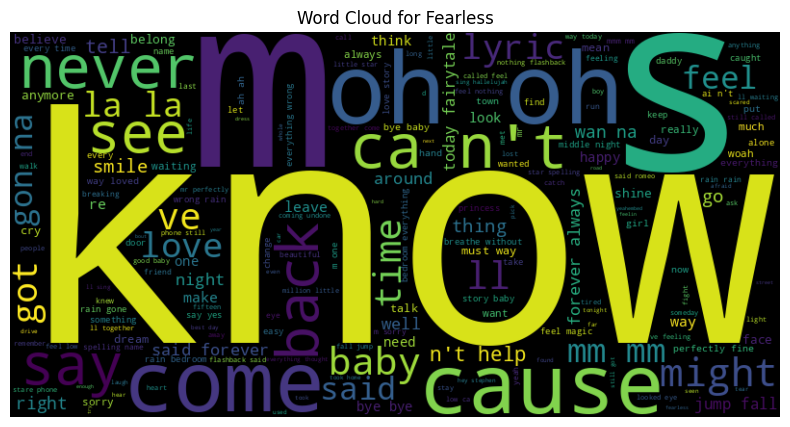

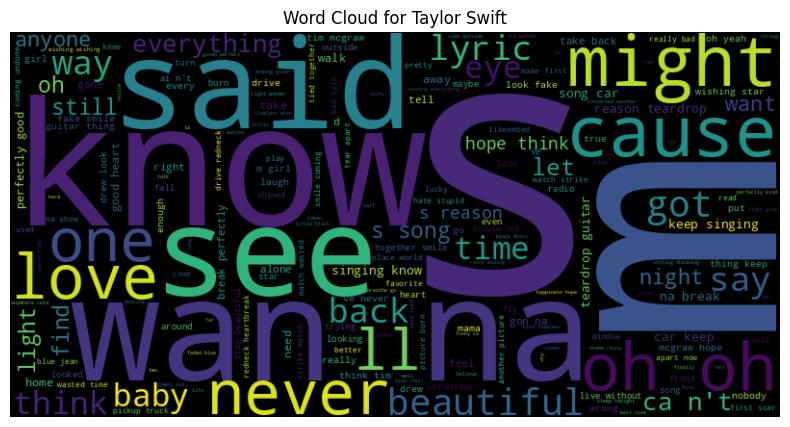

In [9]:
# Word Cloud Visualization for themes in each album
for album in merged_df['Album'].unique():
    album_lyrics = ' '.join(merged_df[merged_df['Album'] == album]['processed_lyrics'])
    wordcloud = WordCloud(width=800, height=400).generate(album_lyrics)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Word Cloud for {album}')
    plt.show()

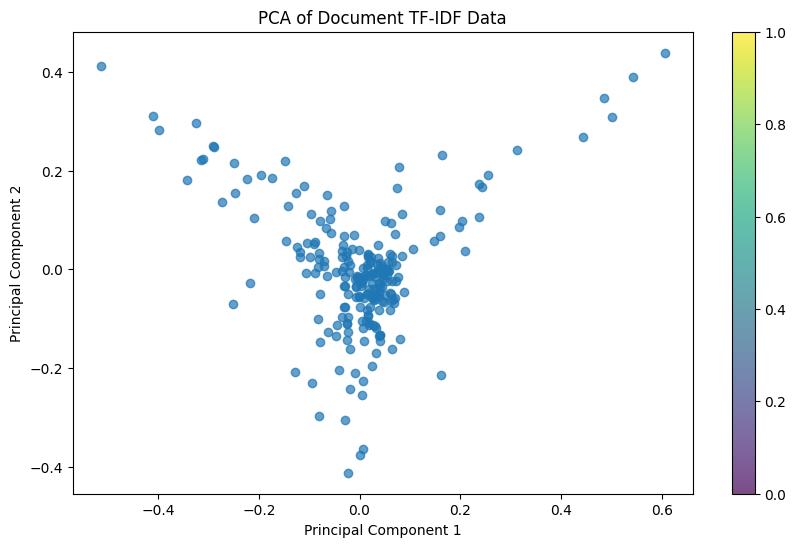

In [10]:
# Dimensionality Reduction - PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for easy visualization
reduced_data_pca = pca.fit_transform(tfidf_matrix.toarray())

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data_pca[:, 0], reduced_data_pca[:, 1], alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Document TF-IDF Data')
plt.colorbar()
plt.show()

/home/ayusee/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


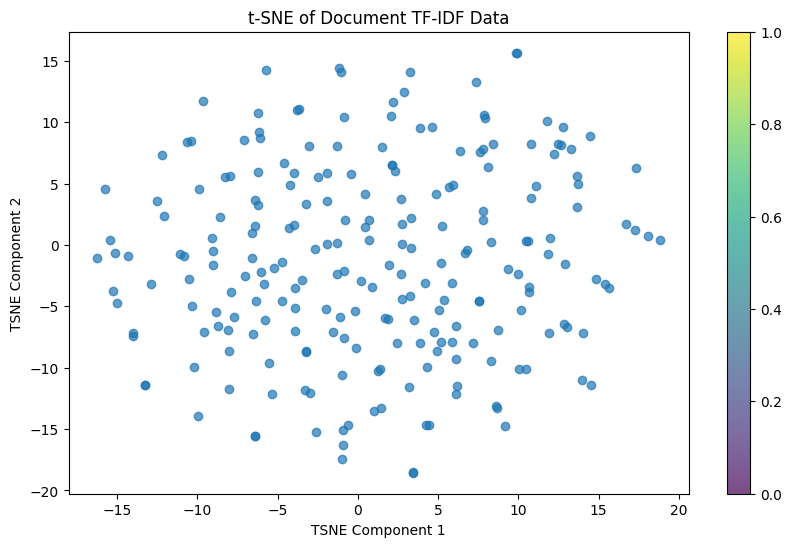

In [11]:
# Visualization - t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(tfidf_matrix.toarray())

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.7)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('t-SNE of Document TF-IDF Data')
plt.colorbar()
plt.show()

In [12]:
# Without applying PCA
# Prepare the data for prediction
X_nmf = nmf_topics
X_lda = lda_topics
y_album = merged_df['Album']
y_year = merged_df['Year']

# Train-test split with stratification to maintain the distribution of classes
X_train_nmf, X_test_nmf, y_train_album, y_test_album = train_test_split(X_nmf, y_album, test_size=0.2, random_state=42, stratify=y_album)
X_train_lda, X_test_lda, y_train_year, y_test_year = train_test_split(X_lda, y_year, test_size=0.2, random_state=42, stratify=y_year)

# Balance the classes using SMOTE
smote = SMOTE(random_state=42)
X_train_nmf_balanced, y_train_album_balanced = smote.fit_resample(X_train_nmf, y_train_album)
X_train_lda_balanced, y_train_year_balanced = smote.fit_resample(X_train_lda, y_train_year)

# Random Forest Classifier for album prediction
rf_album = RandomForestClassifier(n_estimators=100, random_state=42)
rf_album.fit(X_train_nmf_balanced, y_train_album_balanced)
y_pred_album = rf_album.predict(X_test_nmf)

# Random Forest Classifier for year prediction
rf_year = RandomForestClassifier(n_estimators=100, random_state=42)
rf_year.fit(X_train_lda_balanced, y_train_year_balanced)
y_pred_year = rf_year.predict(X_test_lda)

# Evaluate the model performance
def evaluate_model(y_true, y_pred, task_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    print(f"Performance metrics for {task_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}\n")

evaluate_model(y_test_album, y_pred_album, 'Album Prediction (NMF)')
evaluate_model(y_test_year, y_pred_year, 'Year Prediction (LDA)')

# Comparison with SVM
svm_album = make_pipeline(StandardScaler(), SVC(random_state=42))
svm_album.fit(X_train_nmf_balanced, y_train_album_balanced)
y_pred_svm_album = svm_album.predict(X_test_nmf)

svm_year = make_pipeline(StandardScaler(), SVC(random_state=42))
svm_year.fit(X_train_lda_balanced, y_train_year_balanced)
y_pred_svm_year = svm_year.predict(X_test_lda)

evaluate_model(y_test_album, y_pred_svm_album, 'Album Prediction (NMF) with SVM')
evaluate_model(y_test_year, y_pred_svm_year, 'Year Prediction (LDA) with SVM')

# Cross-validation scores
def cross_val_evaluation(model, X, y, task_name):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracy = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    f1 = cross_val_score(model, X, y, cv=skf, scoring='f1_weighted')
    precision = cross_val_score(model, X, y, cv=skf, scoring='precision_weighted')
    recall = cross_val_score(model, X, y, cv=skf, scoring='recall_weighted')
    print(f"Cross-validation metrics for {task_name}:")
    print(f"Accuracy: {np.mean(accuracy):.2f} (+/- {np.std(accuracy):.2f})")
    print(f"F1 Score: {np.mean(f1):.2f} (+/- {np.std(f1):.2f})")
    print(f"Precision: {np.mean(precision):.2f} (+/- {np.std(precision):.2f})")
    print(f"Recall: {np.mean(recall):.2f} (+/- {np.std(recall):.2f})\n")

cross_val_evaluation(rf_album, X_nmf, y_album, 'Album Prediction (NMF) with Random Forest')
cross_val_evaluation(rf_year, X_lda, y_year, 'Year Prediction (LDA) with Random Forest')
cross_val_evaluation(svm_album, X_nmf, y_album, 'Album Prediction (NMF) with SVM')
cross_val_evaluation(svm_year, X_lda, y_year, 'Year Prediction (LDA) with SVM')

/home/ayusee/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ayusee/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ayusee/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Performance metrics for Album Prediction (NMF):
Accuracy: 0.22
F1 Score: 0.21
Precision: 0.22
Recall: 0.22

Performance metrics for Year Prediction (LDA):
Accuracy: 0.22
F1 Score: 0.21
Precision: 0.20
Recall: 0.22

Performance metrics for Album Prediction (NMF) with SVM:
Accuracy: 0.22
F1 Score: 0.21
Precision: 0.24
Recall: 0.22

Performance metrics for Year Prediction (LDA) with SVM:
Accuracy: 0.18
F1 Score: 0.19
Precision: 0.29
Recall: 0.18



/home/ayusee/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ayusee/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ayusee/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ayusee/.local/lib/python3.8/site-packages/sklearn/metrics/_classification

Cross-validation metrics for Album Prediction (NMF) with Random Forest:
Accuracy: 0.21 (+/- 0.04)
F1 Score: 0.18 (+/- 0.04)
Precision: 0.16 (+/- 0.03)
Recall: 0.21 (+/- 0.04)



/home/ayusee/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ayusee/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ayusee/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ayusee/.local/lib/python3.8/site-packages/sklearn/metrics/_classification

Cross-validation metrics for Year Prediction (LDA) with Random Forest:
Accuracy: 0.25 (+/- 0.03)
F1 Score: 0.24 (+/- 0.04)
Precision: 0.24 (+/- 0.06)
Recall: 0.25 (+/- 0.03)

Cross-validation metrics for Album Prediction (NMF) with SVM:
Accuracy: 0.19 (+/- 0.03)
F1 Score: 0.13 (+/- 0.03)
Precision: 0.13 (+/- 0.04)
Recall: 0.19 (+/- 0.03)

Cross-validation metrics for Year Prediction (LDA) with SVM:
Accuracy: 0.26 (+/- 0.03)
F1 Score: 0.18 (+/- 0.03)
Precision: 0.17 (+/- 0.04)
Recall: 0.26 (+/- 0.03)



/home/ayusee/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ayusee/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ayusee/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ayusee/.local/lib/python3.8/site-packages/sklearn/metrics/_classification

In [20]:
# Combine NMF and LDA features
X_combined = np.hstack((nmf_topics, lda_topics))

# Encode the target variables
label_encoder_album = LabelEncoder()
label_encoder_year = LabelEncoder()
y_album_encoded = label_encoder_album.fit_transform(y_album)
y_year_encoded = label_encoder_year.fit_transform(y_year)

# Balance the classes using SMOTE
smote = SMOTE(random_state=42)
X_combined_balanced, y_album_balanced = smote.fit_resample(X_combined, y_album_encoded)

# Applying PCA to the balanced datasets
pca = PCA(n_components=20, random_state=42)  # Combined features so increasing components
X_combined_pca = pca.fit_transform(X_combined_balanced)

# Train-test split with stratification to maintain the distribution of classes
X_train_combined, X_test_combined, y_train_album, y_test_album = train_test_split(X_combined_pca, y_album_balanced, test_size=0.2, random_state=42, stratify=y_album_balanced)

# Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

rf_clf = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train_combined, y_train_album)
best_rf_model = rf_grid_search.best_estimator_

# Predicting with the best Random Forest model
y_pred_rf = best_rf_model.predict(X_test_combined)

# Decode the predictions back to original labels
y_pred_rf_decoded = label_encoder_album.inverse_transform(y_pred_rf)

# Evaluate the Random Forest model performance
def evaluate_model(y_true, y_pred, task_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted')
    print(f"Performance metrics for {task_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}\n")

evaluate_model(y_test_album, y_pred_rf, 'Album Prediction (Combined NMF+LDA) with Random Forest')

# SVM
# Standardize the features
scaler = StandardScaler()
X_train_combined_scaled = scaler.fit_transform(X_train_combined)
X_test_combined_scaled = scaler.transform(X_test_combined)

svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

svm_clf = SVC(random_state=42)
svm_grid_search = GridSearchCV(svm_clf, svm_param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)
svm_grid_search.fit(X_train_combined_scaled, y_train_album)
best_svm_model = svm_grid_search.best_estimator_

# Predicting with the best SVM model
y_pred_svm = best_svm_model.predict(X_test_combined_scaled)

# Decode the predictions back to original labels
y_pred_svm_decoded = label_encoder_album.inverse_transform(y_pred_svm)

# Evaluate the SVM model performance
evaluate_model(y_test_album, y_pred_svm, 'Album Prediction (Combined NMF+LDA) with SVM')

ValueError: n_components=50 must be between 0 and min(n_samples, n_features)=20 with svd_solver='full'

In [18]:
# Combine NMF and LDA features
X_combined = np.hstack((nmf_topics, lda_topics))

# Encode the target variables
label_encoder_album = LabelEncoder()
label_encoder_year = LabelEncoder()
y_album_encoded = label_encoder_album.fit_transform(y_album)
y_year_encoded = label_encoder_year.fit_transform(y_year)

# Balance the classes using SMOTE
smote = SMOTE(random_state=42)
X_combined_balanced, y_album_balanced = smote.fit_resample(X_combined, y_album_encoded)

# Applying PCA to the balanced datasets
pca = PCA(n_components=20, random_state=42)
X_combined_pca = pca.fit_transform(X_combined_balanced)

# Train-test split with stratification
X_train_combined, X_test_combined, y_train_album, y_test_album = train_test_split(X_combined_pca, y_album_balanced, test_size=0.2, random_state=42, stratify=y_album_balanced)

# Random Forest for Album Prediction
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

rf_clf = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train_combined, y_train_album)
best_rf_model = rf_grid_search.best_estimator_

# Predicting with the best Random Forest model
y_pred_rf = best_rf_model.predict(X_test_combined)

# Decode the predictions back to original labels
y_pred_rf_decoded = label_encoder_album.inverse_transform(y_pred_rf)

# Evaluate the Random Forest model performance
def evaluate_model(y_true, y_pred, task_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted')
    print(f"Performance metrics for {task_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}\n")

evaluate_model(y_test_album, y_pred_rf, 'Album Prediction (Combined NMF+LDA) with Random Forest')

# Combine NMF and LDA features for year prediction
X_combined_year = np.hstack((nmf_topics, lda_topics))

# Balance the classes using SMOTE for year prediction
X_combined_year_balanced, y_year_balanced = smote.fit_resample(X_combined_year, y_year_encoded)

# Applying PCA to the balanced datasets for year prediction
X_combined_year_pca = pca.fit_transform(X_combined_year_balanced)

# Train-test split with stratification for year prediction
X_train_combined_year, X_test_combined_year, y_train_year, y_test_year = train_test_split(X_combined_year_pca, y_year_balanced, test_size=0.2, random_state=42, stratify=y_year_balanced)

# Random Forest for Year Prediction
rf_grid_search_year = GridSearchCV(rf_clf, rf_param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)
rf_grid_search_year.fit(X_train_combined_year, y_train_year)
best_rf_model_year = rf_grid_search_year.best_estimator_

# Predicting with the best Random Forest model for year
y_pred_rf_year = best_rf_model_year.predict(X_test_combined_year)

# Decode the predictions back to original labels for year
y_pred_rf_year_decoded = label_encoder_year.inverse_transform(y_pred_rf_year)

# Evaluate the Random Forest model performance for year
evaluate_model(y_test_year, y_pred_rf_year, 'Year Prediction (Combined NMF+LDA) with Random Forest')

# Example: Adding a thematic category column
thematic_categories = {
    'Fearless': 'Love',
    '1989': 'Heartbreak',
    'Red': 'Relationships',
    'Lover': 'Happiness',
    'Folklore': 'Melancholy',
    'Evermore': 'Nostalgia',
    'Reputation': 'Revenge',
    'Midnights': 'Introspection',
    'Taylor Swift': 'Coming of Age',
    'Speak Now': 'Growth'
}

# Map thematic categories to each album
merged_df['Thematic_Category'] = merged_df['Album'].map(thematic_categories)

# Encode the target variable for thematic category
label_encoder_thematic_category = LabelEncoder()
y_thematic_category = merged_df['Thematic_Category']
y_thematic_category_encoded = label_encoder_thematic_category.fit_transform(y_thematic_category)

# Balance the classes using SMOTE
X_combined_thematic_balanced, y_thematic_balanced = smote.fit_resample(X_combined, y_thematic_category_encoded)

# Applying PCA to the balanced datasets
X_combined_thematic_pca = pca.fit_transform(X_combined_thematic_balanced)

# Train-test split with stratification
X_train_combined_thematic, X_test_combined_thematic, y_train_thematic, y_test_thematic = train_test_split(X_combined_thematic_pca, y_thematic_balanced, test_size=0.2, random_state=42, stratify=y_thematic_balanced)

# Random Forest for Thematic Category Prediction
rf_grid_search_thematic = GridSearchCV(rf_clf, rf_param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)
rf_grid_search_thematic.fit(X_train_combined_thematic, y_train_thematic)
best_rf_model_thematic = rf_grid_search_thematic.best_estimator_

# Predicting with the best Random Forest model
y_pred_rf_thematic = best_rf_model_thematic.predict(X_test_combined_thematic)

# Decode the predictions back to original labels
y_pred_rf_thematic_decoded = label_encoder_thematic_category.inverse_transform(y_pred_rf_thematic)

# Evaluate the Random Forest model performance
evaluate_model(y_test_thematic, y_pred_rf_thematic, 'Thematic Category Prediction (Combined NMF+LDA) with Random Forest')

def predict_album_from_lyrics(lyrics):
    # Preprocess lyrics
    lyrics_cleaned = clean_lyrics(lyrics)
    lyrics_no_stopwords = remove_stopwords(lyrics_cleaned)
    lyrics_processed = tokenize_and_lemmatize(lyrics_no_stopwords)
    
    # Extract features
    nmf_topics_lyrics = nmf_model.transform(tfidf_vectorizer.transform([lyrics_processed]))
    lda_topics_lyrics = lda_model.transform(tfidf_vectorizer.transform([lyrics_processed]))
    combined_topics_lyrics = np.hstack((nmf_topics_lyrics, lda_topics_lyrics))
    
    # Apply PCA
    combined_topics_pca_lyrics = pca.transform(combined_topics_lyrics)
    
    # Predict the album using the trained model
    predicted_album_encoded = best_rf_model.predict(combined_topics_pca_lyrics)
    predicted_album = label_encoder_album.inverse_transform(predicted_album_encoded)
    
    print(f"The predicted album for the given lyrics is: {predicted_album[0]}")

def predict_year_from_album(album_name):
    # Find the album in the dataset
    album_data = merged_df[merged_df['Album'] == album_name]
    
    if album_data.empty:
        print("Album not found in the dataset.")
        return
    
    # Combine NMF and LDA features
    album_nmf_topics = nmf_model.transform(tfidf_vectorizer.transform(album_data['processed_lyrics']))
    album_lda_topics = lda_model.transform(tfidf_vectorizer.transform(album_data['processed_lyrics']))
    album_combined_topics = np.hstack((album_nmf_topics, album_lda_topics))
    
    # Apply PCA
    album_combined_pca = pca.transform(album_combined_topics)
    
    # Predict the year using the trained model
    predicted_year_encoded = best_rf_model_year.predict(album_combined_pca)
    predicted_year = label_encoder_year.inverse_transform(predicted_year_encoded)
    
    print(f"The predicted release year for the album '{album_name}' is: {predicted_year[0]}")

def predict_thematic_category_from_lyrics(lyrics):
    # Preprocess lyrics
    lyrics_cleaned = clean_lyrics(lyrics)
    lyrics_no_stopwords = remove_stopwords(lyrics_cleaned)
    lyrics_processed = tokenize_and_lemmatize(lyrics_no_stopwords)
    
    # Extract features
    nmf_topics_lyrics = nmf_model.transform(tfidf_vectorizer.transform([lyrics_processed]))
    lda_topics_lyrics = lda_model.transform(tfidf_vectorizer.transform([lyrics_processed]))
    combined_topics_lyrics = np.hstack((nmf_topics_lyrics, lda_topics_lyrics))
    
    # Apply PCA
    combined_topics_pca_lyrics = pca.transform(combined_topics_lyrics)
    
    # Predict the thematic category using the trained model
    predicted_thematic_encoded = best_rf_model_thematic.predict(combined_topics_pca_lyrics)
    predicted_thematic = label_encoder_thematic_category.inverse_transform(predicted_thematic_encoded)
    
    print(f"The predicted thematic category for the given lyrics is: {predicted_thematic[0]}")

# Test the functions
predict_album_from_lyrics("We were both young when I first saw you...")
predict_year_from_album("Fearless")
predict_thematic_category_from_lyrics("We were both young when I first saw you...")

Performance metrics for Album Prediction (Combined NMF+LDA) with Random Forest:
Accuracy: 0.49
F1 Score: 0.46
Precision: 0.58
Recall: 0.49

Performance metrics for Year Prediction (Combined NMF+LDA) with Random Forest:
Accuracy: 0.72
F1 Score: 0.70
Precision: 0.73
Recall: 0.72

Performance metrics for Thematic Category Prediction (Combined NMF+LDA) with Random Forest:
Accuracy: 0.71
F1 Score: 0.69
Precision: 0.70
Recall: 0.71

The predicted album for the given lyrics is: Reputation
The predicted release year for the album 'Fearless' is: 2014
The predicted thematic category for the given lyrics is: Relationships


In [19]:
# Test the functions with more lyrics
test_lyrics_1 = "We were both young when I first saw you..."  # From "Love Story" (Album: Fearless)
test_lyrics_2 = "I'm sorry, the old Taylor can't come to the phone right now..."  # From "Look What You Made Me Do" (Album: Reputation)

predict_album_from_lyrics(test_lyrics_1)
predict_year_from_album("Fearless")
predict_thematic_category_from_lyrics(test_lyrics_1)

predict_album_from_lyrics(test_lyrics_2)
predict_year_from_album("Reputation")
predict_thematic_category_from_lyrics(test_lyrics_2)

The predicted album for the given lyrics is: Reputation
The predicted release year for the album 'Fearless' is: 2014
The predicted thematic category for the given lyrics is: Relationships
The predicted album for the given lyrics is: Red
The predicted release year for the album 'Reputation' is: 2022
The predicted thematic category for the given lyrics is: Revenge
